In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [2]:
np.random.seed(1)

# Gaussian Processes Regression

A random variable $X$ presents a Gaussian distribution with mean $\mu$ and variance $\sigma^{2}$
if its probability density function (PDF) is:
$$
P_{X}(x)=\frac{1}{\sqrt{2\pi}\sigma}\exp{\left(-\frac{(x-\mu)^{2}}{2\sigma^ {2}}\right)}
$$

In [3]:
# General form of a Gaussian distribution
def dist(x, mu, sigma2):
    return((1/(np.sqrt(2*np.pi*sigma2))*np.exp(-(x-mu)**2/(2*sigma2))))

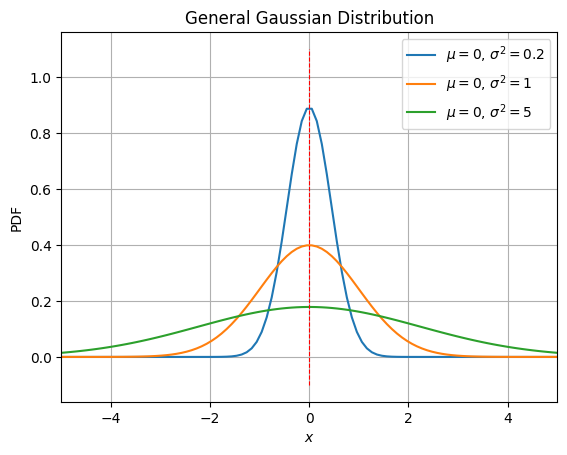

In [4]:
xs=np.linspace(-5,5,100)

plt.plot(xs,dist(xs,0,0.2),label="$\mu=0$, $\sigma^{2}=0.2$")
plt.plot(xs,dist(xs,0,1),label="$\mu=0$, $\sigma^{2}=1$")
plt.plot(xs,dist(xs,0,5),label="$\mu=0$, $\sigma^{2}=5$")
plt.grid()
plt.xlabel("$x$")
plt.ylabel("PDF")
plt.xlim(-5,5)
plt.vlines(0,-0.1,1.1,linestyle="dashed",color="red",linewidth=0.8)
plt.title("General Gaussian Distribution")
plt.savefig("NormalDistribution")
plt.legend();

Since any Gaussian distribution is characterized by the parameters $\mu$ and $\sigma^{2}$, it can be denoted as:
$$
P_{X}(x)=\mathcal{N}(\mu,\sigma^{2})
$$
For two random variables with Gaussian distributions, we have a multivariate distribution. The parameter $\mu$ becomes into a vector with the means and $\sigma^{2}$ into a covariance matrix with the correlation information between the variables:
$$
P_{X_{1},X_{2}}(x,y)=\mathcal{N}\left(\left[\begin{matrix}\mu_1\\\mu_2\end{matrix}\right],
\left[\begin{matrix}\sigma_{X_{1}}^{2}&\sigma_{X_{1},x_{2}}^{2}\\\sigma_{X_{2},x_{ 1}}^{2}&\sigma_{X_{2}}^{2}\end{matrix}\right]\right)
$$
The above can be generalized to the case of infinitely many random variables where $\mu$ is transformed into a continuous function of averages $m(x)$ and the covariance matrix into a covariance function $k(x,x')$, designated as kernel:
$$
f(x)\sim\mathcal{GP}(m(x),k(x,x'))
$$
This is known as a Gaussian process and it is defined as a collection of random variables where each subset of them has a Gaussian distribution.
In conjunction with Bayesian statistical tools, they have applications in regression and classification problems.

## Regression of a linear model using _scikit learn_.

The simplest form of regression consists on ignoring the variance or noise of the observational data, which means assuming that the measurements in the observations have no uncertainties.

The file `Linear_example.txt` contains a mock data set that was constructed from a linear function. A random value was added to the independent variable $y$ to generate random scatter in the data.


In [5]:
# Reading data
data=pd.read_table('Linear_example.txt',sep='\s+')

# Independent variable in the data
x=np.atleast_2d(np.asarray(data)[:,0]).T

# Dependent variable in the data
y=np.asarray(data)[:,1]

* Null variances:

In [6]:
# MODEL ESTIMATION
# Prior
k = C(1.0)*Matern()
gp = GaussianProcessRegressor(kernel=k, n_restarts_optimizer=20)

# Inference
gp.fit(x, y);

# Values where the model is evaluated to make predictions
xs = np.atleast_2d(np.linspace(1, 10, 1000)).T

# Predictions and standard deviations of each
y_pred, sigma = gp.predict(xs, return_std=True)

In [7]:
def graph(f,sigma):
    plt.scatter(x,y,color="black",s=12,label=u'Data')
    plt.plot(xs, f, label=u'Model',color="midnightblue")
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 1.96*sigma,
                        (f + 1.96*sigma)[::-1]]), color="blueviolet",
             alpha=.35, ec='None', label='1$\sigma$')
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 2.576 * sigma,
                        (f + 2.576 * sigma)[::-1]]), color="blue",
         alpha=.15, ec='None', label='2$\sigma$')
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper left')
    plt.grid();

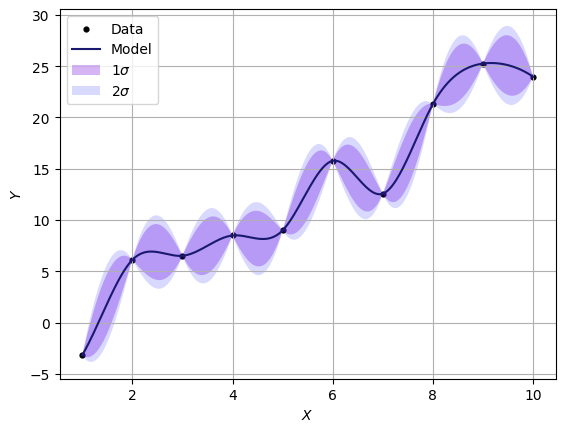

In [8]:
graph(y_pred,sigma)
plt.savefig("LinearGP");

* Random variances:

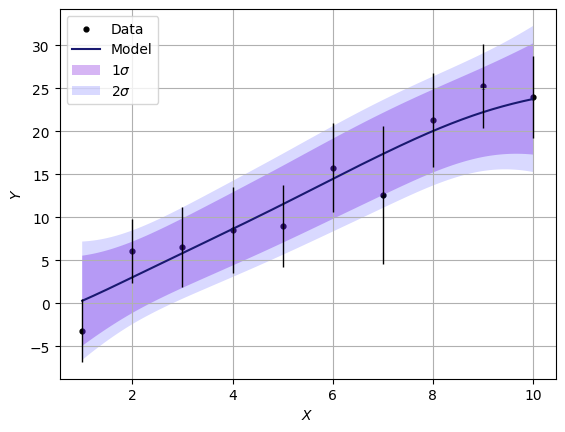

In [9]:
# Random variances in the data
dy = np.random.normal(5,2*np.random.rand(len(y)))

# Estimation of the model
k = C(1.0)*Matern()
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

y_pred, sigma = gp.predict(xs, return_std=True)

graph(y_pred,sigma)
plt.errorbar(x.ravel(), y, dy,linestyle="None", elinewidth=1,
                color="black")
plt.savefig("LinearErrorGP");

## Estimation of the derivatives of a function using _GaPP_

In [10]:
import gapp

from gapp import gp
from gapp import dgp
from gapp import covariance

In [11]:
X=np.linspace(0,2*np.pi,30); Y=np.sin(X); Sigma=np.random.uniform(0,0.5,len(X))

xmin = 0.0
xmax = 2*np.pi
nstar = 200
initheta = [60.0,60.0]
g = dgp.DGaussianProcess(X, Y, Sigma, cXstar = (xmin, xmax, nstar))

(rec, theta) = g.gp(theta = initheta)
(drec, theta) = g.dgp(thetatrain = 'False')
(d2rec, theta) = g.d2gp()
(d3rec, theta) = g.d3gp()


Optimized hyperparameters:
theta = [0.90637371 1.69333862]


In [12]:
def plot(X, Y, Sigma, rec, drec, d2rec, d3rec,xlim_a,xlim_b,ylim_a,ylim_b):

    fig, axs = plt.subplots(2, 2, figsize=(13,8))    
    
    axs[0,0].fill_between(rec[:, 0], rec[:, 1] + 1.96*rec[:, 2], rec[:, 1] - 1.96*rec[:, 2],
                     facecolor='blueviolet',alpha=.35)
    axs[0,0].fill_between(rec[:, 0], rec[:, 1] + 2.576*rec[:, 2], rec[:, 1] - 2.576*rec[:, 2],
                     facecolor='blue',alpha=.15)
    axs[0,0].scatter(X,Y,s=12,color="black")
    axs[0,0].plot(rec[:, 0], rec[:, 1],color='midnightblue')
    axs[0,0].errorbar(X, Y, Sigma, color='black',elinewidth=1,linestyle='None')
    axs[0,0].set_xlabel("$x$", fontsize=17)
    axs[0,0].set_ylabel("$y$", fontsize=17)
    axs[0,0].grid()
    axs[0,0].set_xlim([xlim_a, xlim_b])
    axs[0,0].set_ylim([ylim_a, ylim_b]) 
    
    axs[0,1].fill_between(drec[:, 0], drec[:, 1] + 1.96*drec[:, 2], 
                     drec[:, 1] - 1.96*drec[:, 2], facecolor='blueviolet',alpha=.35)
    axs[0,1].fill_between(drec[:, 0], drec[:, 1] + 2.576*drec[:, 2], 
                     drec[:, 1] - 2.576*drec[:, 2], facecolor='blue',alpha=.15)
    axs[0,1].plot(drec[:, 0], drec[:, 1],color='midnightblue')
    axs[0,1].set_xlabel("$x$", fontsize=17)
    axs[0,1].set_ylabel("$y'$", fontsize=17)
    axs[0,1].grid()
    axs[0,1].set_xlim([xlim_a, xlim_b])
    axs[0,1].set_ylim([ylim_a, ylim_b])  
    
    axs[1,0].fill_between(d2rec[:, 0], d2rec[:, 1] + 1.96*d2rec[:, 2], 
                     d2rec[:, 1] - 1.96*d2rec[:, 2], facecolor='blueviolet',alpha=.35)
    axs[1,0].fill_between(d2rec[:, 0], d2rec[:, 1] + 2.576*d2rec[:, 2], 
                     d2rec[:, 1] - 2.576*d2rec[:, 2], facecolor='blue',alpha=.15)
    axs[1,0].plot(d2rec[:, 0], d2rec[:, 1],color='midnightblue')
    axs[1,0].set_xlabel("$x$", fontsize=17)
    axs[1,0].set_ylabel("$y''$", fontsize=17)
    axs[1,0].grid()
    axs[1,0].set_xlim([xlim_a, xlim_b])
    axs[1,0].set_ylim([ylim_a, ylim_b])
    
    axs[1,1].fill_between(d3rec[:, 0], d3rec[:, 1] + 1.96*d3rec[:, 2], 
                     d3rec[:, 1] - 1.96*d3rec[:, 2], facecolor='blueviolet',alpha=.35)
    axs[1,1].fill_between(d3rec[:, 0], d3rec[:, 1] + 2.576*d3rec[:, 2], 
                     d3rec[:, 1] - 2.576*d3rec[:, 2], facecolor='blue',alpha=.15)
    axs[1,1].plot(d3rec[:, 0], d3rec[:, 1],color='midnightblue')
    axs[1,1].set_xlabel("$x$", fontsize=17)
    axs[1,1].set_ylabel("$y'''$", fontsize=17)
    axs[1,1].grid()
    axs[1,1].set_xlim([xlim_a, xlim_b])
    axs[1,1].set_ylim([ylim_a, ylim_b]);

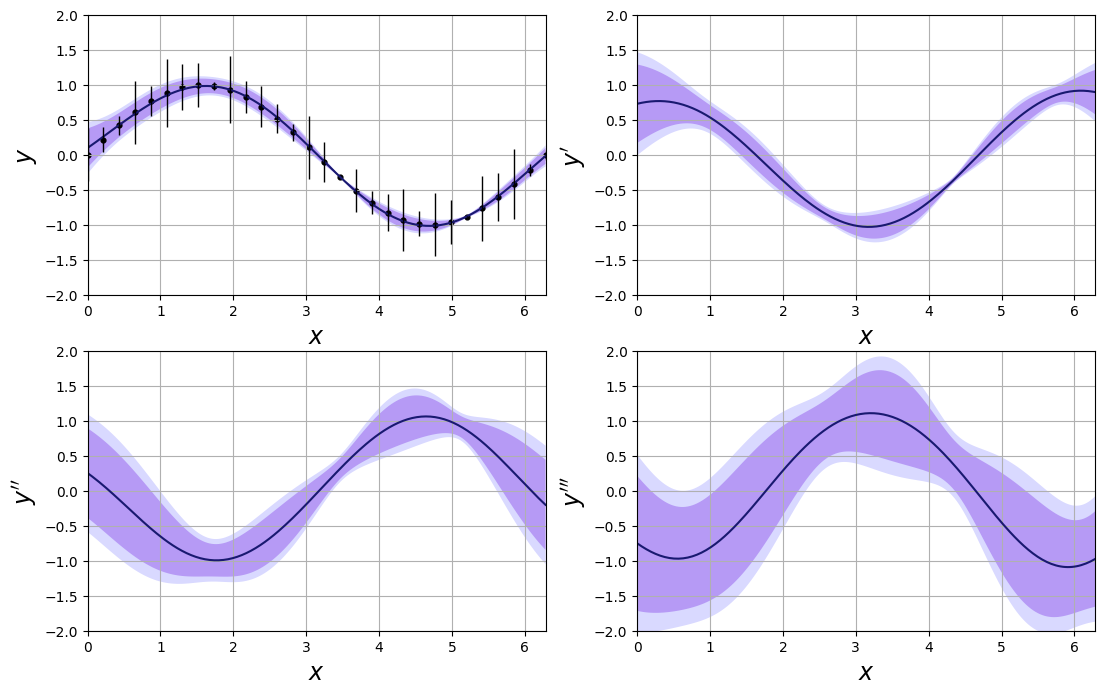

In [13]:
plot(X, Y, Sigma, rec, drec, d2rec, d3rec,0,2*np.pi,-2,2)
plt.savefig('Derivatives');